# <center> **Cardiotocography (22% of outliers)**
Data set related to heart diseases. It describes 3 classes: normal, suspect, or pathological. Normal patients are treated as inliers and the remaining as outliers.

# Table of Contents

1. **[Functions](#1)**
2. **[Data description](#2)**
3. **[EDA](#3)**
	* [Target variable](#sub-heading5)
	* [Numeric features](#sub-heading6)
	* [Correlation](#sub-heading7)
	* [Correlation coefficients](#sub-heading)
	* [Dropping highly correlated features](#sub-heading)
4. **[Preprocessing](#4)**
	* [Dropping duplicates](#sub-heading)
	* [Log transformation](#sub-heading)
	* [PCA](#sub-heading)
	* [Split](#sub-heading)
5. **[Metrics](#5)**
6. **[Mahalanobis rule](#6)**
	* [Detection of multidimensional outliers using the Mahalanobis distance](#sub-heading)
	* [Mahalanobis distance for classification problems](#sub-heading)
7. **[Supervised models](#7)**
	* [Standartisation](#sub-heading)
	* [SMOTE](#sub-heading)
	* [SVM](#sub-heading)
	* [Logistic regression](#sub-heading)
	* [KNN](#sub-heading)
	* [Compare different SUPERVISED models (select the best)](#sub-heading)
8. **[Unsupervised models](#8)**
	* [Standartisation](#sub-heading)
	* [One-class SVM](#sub-heading)
	* [Isolation Forest](#sub-heading)
	* [Compare different UNSUPERVISED models (select the best)](#sub-heading)






In [51]:
!pip install scikit-plot

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 
import warnings
warnings.simplefilter('ignore')

import pylab as pl

from scipy import stats
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
from scipy.stats import norm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

import scikitplot as skplt 
from scipy.spatial.distance import pdist, mahalanobis, squareform
import scipy as sp
from scipy.stats import chi2
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/My Drive/DA/HW8/Cardiotocography.csv', sep=',')

# **Functions**

**Plotting histograms**

In [4]:
def draw_histogram(data):
    f,ax_hist = plt.subplots(1)
    sns.distplot(data, hist=True,  kde=True, rug=True, bins=10, fit=norm, ax=ax_hist);
    plt.xlabel("values")
    plt.title("Distribution") 

    mean=data.mean()

    ax_hist.axvline(mean, color='r', linestyle='--', label=f"Mean={mean:.3f}")
    ax_hist.legend()

    plt.show()

In [5]:
def draw_lognorm(data):
    f,ax_hist = plt.subplots(1)
    sns.distplot(data, hist=True,  kde=True, rug=True, bins=10, fit=norm, ax=ax_hist)
    plt.title("Distribution BEFORE Log transformation")
    plt.xlabel("values")
    mean=data.mean()
    ax_hist.axvline(mean, color='r', linestyle='--', label=f"Mean={mean:.3f}")
    ax_hist.legend()
    sns.despine()
    plt.show()

    f,ax_hist = plt.subplots(1)
    sns.distplot(np.log1p(data), hist=True,  kde=True, rug=True, fit=norm,  ax=ax_hist)
    plt.title("Distribution AFTER Log transformation")
    plt.xlabel("values")
    mean=np.log1p(data).mean()
    ax_hist.axvline(mean, color='r', linestyle='--', label=f"Mean={mean:.3f}")
    ax_hist.legend()
    sns.despine()

    plt.show()

In [6]:
def count_skewness_kurtosis(data):
    print("Skewness: %f" % data.skew())
    print("Kurtosis: %f" % data.kurt())

**Normality Tests**  
1) Shapiro-Wilk Test  
Tests whether a data sample has a Gaussian distribution.  

*Assumptions*  

Observations in each sample are independent and identically distributed (iid).  

*Interpretation*  

H0: the sample has a Gaussian distribution.  
H1: the sample does not have a Gaussian distribution.  

In [7]:
def shapiro_normality_testing(data):
  stat, p = shapiro(data)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
    print('Probably Gaussian')
  else:
    print('Probably not Gaussian')

**Quality evaluation**

In [8]:
!ls

%cd /content/drive/My Drive/DA/HW5/

from plot_cm import plot_confusion_matrix

drive  sample_data
/content/drive/My Drive/DA/HW5


In [9]:
from plot_roc import plot_roc

In [10]:
def calc_metrics1(test_label, preds, outlier_label =-1):
    preds[preds != outlier_label] = 0
    preds[preds == outlier_label] = 1

    skplt.metrics.plot_confusion_matrix(test_label, preds, 
                                    normalize=False,
                                    title="Consfusion Matrix on Test Set")
    plt.show()

    print('\n\nClassification report:\n')
    print(metrics.classification_report(test_label, preds, digits=5))

**ROC AUC**

In [11]:
def count_roc_auc(model, testData, test_label):
    preds_prob = model.predict_proba(testData)

    classes_names = ['0', '1']
    num_classes = 2

    print('ROC AUC:',
         '\n    macro:', round(metrics.roc_auc_score(test_label, preds_prob, multi_class='ovr', average='macro'), 5),
         '\n    weighted:', round(metrics.roc_auc_score(test_label, preds_prob, multi_class='ovr', average='weighted'), 5))

    test_label_bin = label_binarize(test_label, classes=np.arange(num_classes))

    plot_roc(test_label_bin, preds_prob, target_names=classes_names)

In [12]:
def count_rocauc_classif(model, testData, test_label):
    preds_prob = model.decision_function(testData)

    classes_names = ['0', '1']
    num_classes = 2
    print('ROC AUC:',
          '\n    macro:', round(metrics.roc_auc_score(test_label, preds_prob, multi_class='ovr', average='macro'), 5),
          '\n    weighted:', round(metrics.roc_auc_score(test_label, preds_prob, multi_class='ovr', average='weighted'), 5))

    plot_roc(test_label, preds_prob, target_names=classes_names)

# **Data description**

<p align="right">
  <img src="https://miro.medium.com/max/1750/1*wyKbjaeFy2IzSVf-UHDAmA.png" width="600">
</p>

In [13]:
data.shape

(16880, 23)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16880 entries, 0 to 16879
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        16880 non-null  float64
 1   LB        16880 non-null  float64
 2   AC        16880 non-null  float64
 3   FM        16880 non-null  float64
 4   UC        16880 non-null  float64
 5   ASTV      16880 non-null  float64
 6   MSTV      16880 non-null  float64
 7   ALTV      16880 non-null  float64
 8   MLTV      16880 non-null  float64
 9   DL        16880 non-null  float64
 10  DS        16880 non-null  float64
 11  DP        16880 non-null  float64
 12  Width     16880 non-null  float64
 13  Min       16880 non-null  float64
 14  Max       16880 non-null  float64
 15  Nmax      16880 non-null  float64
 16  Nzeros    16880 non-null  float64
 17  Mode      16880 non-null  float64
 18  Mean      16880 non-null  float64
 19  Median    16880 non-null  float64
 20  Variance  16880 non-null  fl

In [15]:
data.isnull().sum()

id          0
LB          0
AC          0
FM          0
UC          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
DL          0
DS          0
DP          0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
outlier     0
dtype: int64

In [16]:
data.head().T

,0,1,2,3,4
id,1881,421,92,1767,1880
LB,0.592593,0.574074,0.777778,0.259259,0.592593
AC,0,0.0384615,0,0,0
FM,0,0,0,0,0.00177305
UC,0.294118,0,0,0.294118,0.294118
ASTV,0.633803,0.816901,0.774648,0.704225,0.633803
MSTV,0.338235,0.0294118,0.0294118,0.191176,0.352941
ALTV,0,0.527473,0.736264,0,0
MLTV,0.0138067,0.0927022,0.0966469,0.183432,0.0138067
DL,0.5,0,0,0.428571,0.428571


# **EDA**

In [17]:
cdata = data.copy(deep=True)

In [18]:
target = 'outlier'

features = list(cdata.columns)
features.remove(target)
features

['id',
 'LB',
 'AC',
 'FM',
 'UC',
 'ASTV',
 'MSTV',
 'ALTV',
 'MLTV',
 'DL',
 'DS',
 'DP',
 'Width',
 'Min',
 'Max',
 'Nmax',
 'Nzeros',
 'Mode',
 'Mean',
 'Median',
 'Variance',
 'Tendency']

In [19]:
cdata.loc[:, 'outlier'].replace("b'yes'", 1, inplace=True)
cdata.loc[:, 'outlier'].replace("b'no'", 0, inplace=True)

In [20]:
x_data = cdata[features]
y_data = cdata[target]

Descriptive statistics for numerical and categorical features.

In [21]:
cdata.describe(include='all')

,id,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,outlier
count,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000
mean,1123.872156,0.483186,0.129270,0.011411,0.226668,0.425672,0.179521,0.064739,0.170819,0.113227,0.000770,0.017417,0.391083,0.379411,0.365604,0.230579,0.033365,0.563887,0.525497,0.475086,0.090984,0.670794,0.019550
std,593.610901,0.175738,0.143077,0.060514,0.156665,0.216970,0.121198,0.146732,0.114551,0.171935,0.027742,0.084956,0.214992,0.252147,0.153285,0.159211,0.069209,0.128429,0.136375,0.146790,0.119737,0.295171,0.138451
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,641.000000,0.351852,0.000000,0.000000,0.117647,0.236111,0.088235,0.000000,0.094675,0.000000,0.000000,0.000000,0.204678,0.155963,0.258621,0.111111,0.000000,0.482143,0.431193,0.373494,0.015385,0.500000,0.000000
50%,1150.500000,0.481481,0.076923,0.000000,0.235294,0.408451,0.161765,0.000000,0.155819,0.000000,0.000000,0.000000,0.377907,0.376147,0.353448,0.222222,0.000000,0.567797,0.525773,0.478261,0.045198,0.500000,0.000000
75%,1619.000000,0.592593,0.192308,0.003546,0.304348,0.608108,0.220588,0.050633,0.226824,0.214286,0.000000,0.000000,0.549133,0.596330,0.456897,0.333333,0.000000,0.650000,0.621053,0.576087,0.122677,1.000000,0.000000
max,2126.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Conclusion**  

* Since we are working with distances between objects, heterogeneity in the values of features can greatly distort the results of the analysis. So, a feature that itself takes high values can be decisive when calculating distances, while features with low values may have almost no effect.

* To solve this problem, I later perform *STANDARDIZATION* of the data.

## **Target variable**

In [22]:
y_data.value_counts()

0    16550
1      330
Name: outlier, dtype: int64

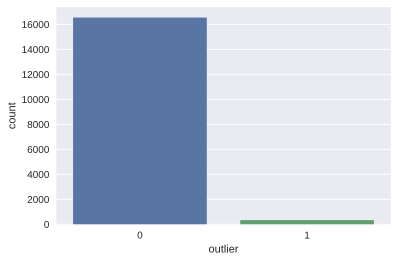

In [23]:
sns.countplot(x='outlier',data=cdata)
plt.show()

**Conclusion**

* The target value in the dataset looks imbalanced as the number of negative samples is much higher than the positive class.

* In the future, I'm going to use the *'SMOTE'* algorithm to avoid the problem of data imbalance.




## **Numeric features**

**'LB'**

In [138]:
draw_histogram(x_data['LB'])

Output hidden; open in https://colab.research.google.com to view.

In [139]:
count_skewness_kurtosis(x_data['LB'])

Skewness: 0.070211
Kurtosis: -0.135805


* *Skewness* shows how symmetric the data is, from the value it is clear that the data is NOT strongly biased.
* *Kurtosis* shows that the distribution is not flattened and has small tails.

In [140]:
shapiro_normality_testing(x_data['LB'])

stat=0.994, p=0.000
Probably not Gaussian


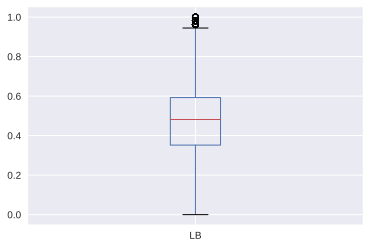

In [141]:
x_data.boxplot(column=['LB'])
plt.show()

**Conclusion** 

* This feature has a very small amount of outlaiers, near 0.9+.
* The median is around 0.5.


**'AC'**

In [142]:
draw_histogram(x_data['AC'])

Output hidden; open in https://colab.research.google.com to view.

In [143]:
shapiro_normality_testing(x_data['AC'])

stat=0.841, p=0.000
Probably not Gaussian


In [144]:
count_skewness_kurtosis(x_data['AC'])

Skewness: 1.397589
Kurtosis: 2.257366


* *Skewness* shows how symmetric the data is, from the value it is clear that the data is strongly biased.
* *Kurtosis* shows that the distribution is not flattened and has a long tail.
* Data looks like needed to be log transformed.

**Log transformation**

In [145]:
draw_lognorm(x_data['AC'])

Output hidden; open in https://colab.research.google.com to view.

**Conclusion:**  

* I'd say it looks more like a log-normal distribution, so we can try to apply log transformation.
* After log transformation the distribution resembles a normal one, but still has many zeros, but the average values are slightly shifted to the left, while the distribution has a tail. However, the variance has become less.

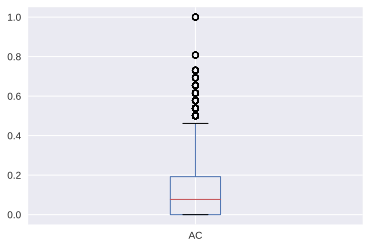

In [146]:
x_data.boxplot(column=['AC'])
plt.show()

**Conclusion** 
* This feature has a very small amount of outlaiers, near 0.45+.
* The median is around 0.129, and 0.114 after log transformation.

**'FM'**

In [147]:
x_data['FM'].value_counts()

0.000000    10887
0.001773     1416
0.003546      920
0.005319      608
0.007092      521
            ...  
0.287234        2
0.539007        2
0.258865        1
0.785461        1
0.342199        1
Name: FM, Length: 87, dtype: int64

In [148]:
draw_histogram(x_data['FM'])

Output hidden; open in https://colab.research.google.com to view.

In [149]:
shapiro_normality_testing(x_data['FM'])

stat=0.171, p=0.000
Probably not Gaussian


In [150]:
count_skewness_kurtosis(x_data['FM'])

Skewness: 10.639654
Kurtosis: 135.533593


* *Skewness* shows how symmetric the data is, from the value it is clear that the data is strongly biased.
* *Kurtosis* shows that the distribution is not flattened and has a long tail.
* Data looks like needed to be log transformed.

**Log transformation**

In [151]:
draw_lognorm(x_data['FM'])

Output hidden; open in https://colab.research.google.com to view.

**Conclusion:**  

* There are a lot of zero-values and log transform. has a very poor effect.
* The average values are slightly shifted to the right, while the distribution has a small tails. However, the variance has become less.

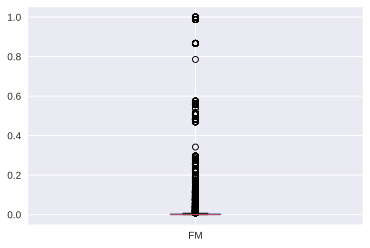

In [152]:
x_data.boxplot(column=['FM'])
plt.show()

**Conclusion** 
* This feature has a lot of outlaiers, near 0.0+.
* The median is around 0.011, and 0.010 after log transformation.

**'UC'**

In [153]:
draw_histogram(x_data['UC'])

Output hidden; open in https://colab.research.google.com to view.

In [154]:
shapiro_normality_testing(x_data['UC'])

stat=0.951, p=0.000
Probably not Gaussian


In [155]:
count_skewness_kurtosis(x_data['UC'])

Skewness: 0.726470
Kurtosis: 0.705297


* *Skewness* shows how symmetric the data is, from the value it is clear that the data is biased.
* *Kurtosis* shows that the distribution is not flattened and has a tail.
* Data looks like needed to be log transformed.

**Log transformation**

In [156]:
draw_lognorm(x_data['UC'])

Output hidden; open in https://colab.research.google.com to view.

**Conclusion:**  

* I'd say it looks more like a log-normal distribution, so we can try to apply log transformation.
* After log transformation the distribution resembles a normal one, but the average values are slightly shifted to the right, while the distribution has a small tails. However, the variance has become less.

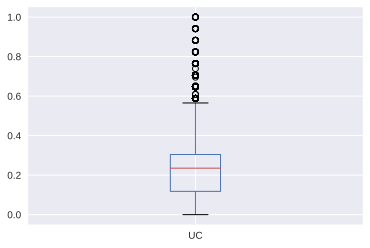

In [157]:
x_data.boxplot(column=['UC'])
plt.show()

**Conclusion** 
* This feature has a very small amount of outlaiers, near 0.55+.
* The median is around 0.2, and 0.1 after log transformation.

**'ASTV'**

In [158]:
draw_histogram(x_data['ASTV'])

Output hidden; open in https://colab.research.google.com to view.

In [159]:
shapiro_normality_testing(x_data['ASTV'])

stat=0.970, p=0.000
Probably not Gaussian


In [160]:
count_skewness_kurtosis(x_data['ASTV'])

Skewness: 0.151495
Kurtosis: -0.972806


* *Skewness* shows how symmetric the data is, from the value it is clear that the data is not biased.
* *Kurtosis* shows that the distribution is not flattened.

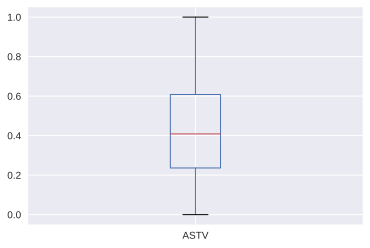

In [161]:
x_data.boxplot(column=['ASTV'])
plt.show()

**Conclusion** 
* This feature has not outlaiers.
* The median is around 0.4.

**'MSTV'**

In [162]:
draw_histogram(x_data['MSTV'])

Output hidden; open in https://colab.research.google.com to view.

In [163]:
shapiro_normality_testing(x_data['MSTV'])

stat=0.868, p=0.000
Probably not Gaussian


In [164]:
count_skewness_kurtosis(x_data['MSTV'])

Skewness: 1.807709
Kurtosis: 5.510427


* *Skewness* shows how symmetric the data is, from the value it is clear that the data is strongly biased.
* *Kurtosis* shows that the distribution is not flattened and has a long tail.
* Data looks like needed to be log transformed.

**Log transformation**

In [165]:
draw_lognorm(x_data['MSTV'])

Output hidden; open in https://colab.research.google.com to view.

**Conclusion:**  

* I'd say it looks more like a log-normal distribution, so we can try to apply log transformation.
* After log transformation the distribution resembles a normal one, but the average values are slightly shifted to the right, while the distribution has a small tails. However, the variance has become less.

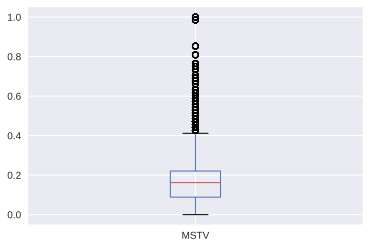

In [166]:
x_data.boxplot(column=['MSTV'])
plt.show()

**Conclusion** 
* This feature has a  many outlaiers, near 0.42+.
* The median is around 0.18, and 0.16 after log transformation.

**'ALTV'**

In [167]:
draw_histogram(x_data['ALTV'])

Output hidden; open in https://colab.research.google.com to view.

In [168]:
shapiro_normality_testing(x_data['ALTV'])

stat=0.514, p=0.000
Probably not Gaussian


In [169]:
count_skewness_kurtosis(x_data['ALTV'])

Skewness: 3.025023
Kurtosis: 9.704552


* *Skewness* shows how symmetric the data is, from the value it is clear that the data is strongly biased.
* *Kurtosis* shows that the distribution is not flattened and has a long tail.
* Data looks like needed to be log transformed.

**Log transformation**

In [170]:
draw_lognorm(x_data['ALTV'])

Output hidden; open in https://colab.research.google.com to view.

**Conclusion:**  

* I'd say it looks more like a log-normal distribution, so we can try to apply log transformation.
* After log transformation the distribution resembles a normal one, but the average values are slightly shifted to the left, while the distribution has a small tails. However, the variance has become less.

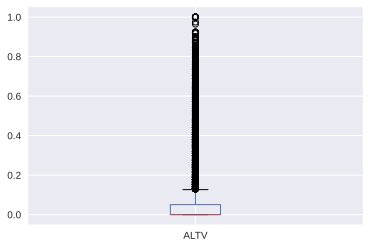

In [171]:
x_data.boxplot(column=['ALTV'])
plt.show()

**Conclusion** 
* This feature has a lot of outlaiers, near 0.1+.
* The median is around 0.065, and 0.055 after log transformation.

**'MLTV'**

In [172]:
draw_histogram(x_data['MLTV'])

Output hidden; open in https://colab.research.google.com to view.

In [173]:
shapiro_normality_testing(x_data['MLTV'])

stat=0.926, p=0.000
Probably not Gaussian


In [174]:
count_skewness_kurtosis(x_data['MLTV'])

Skewness: 1.311805
Kurtosis: 3.935255


* *Skewness* shows how symmetric the data is, from the value it is clear that the data is strongly biased.
* *Kurtosis* shows that the distribution is not flattened and has a long tail.
* Data looks like needed to be log transformed.

**Log transformation**

In [175]:
draw_lognorm(x_data['MLTV'])

Output hidden; open in https://colab.research.google.com to view.

**Conclusion:**  

* I'd say it looks more like a log-normal distribution, so we can try to apply log transformation.
* After log transformation the distribution resembles a normal one, but the average values are slightly shifted to the right, while the distribution has a small tails. However, the variance has become less.

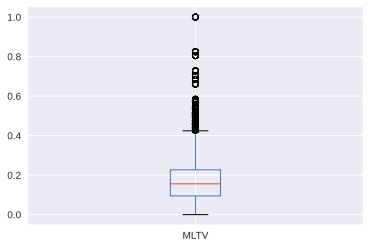

In [176]:
x_data.boxplot(column=['MLTV'])
plt.show()

**Conclusion** 
* This feature has some outlaiers, near 0.45+.
* The median is around 0.17, and 0.15 after log transformation.

**'DL'**

In [177]:
draw_histogram(x_data['DL'])

Output hidden; open in https://colab.research.google.com to view.

In [178]:
shapiro_normality_testing(x_data['DL'])

stat=0.712, p=0.000
Probably not Gaussian


In [179]:
count_skewness_kurtosis(x_data['DL'])

Skewness: 1.697292
Kurtosis: 2.686807


* *Skewness* shows how symmetric the data is, from the value it is clear that the data is strongly biased.
* *Kurtosis* shows that the distribution is not flattened and has a long tail.
* Data looks like needed to be log transformed.

**Log transformation**

In [180]:
draw_lognorm(x_data['DL'])

Output hidden; open in https://colab.research.google.com to view.

**Conclusion:**  

* I'd say it looks more like a log-normal distribution, so we can try to apply log transformation.
* After log transformation the distribution resembles a normal one, but the average values are slightly shifted to the left, while the distribution has a small tails. However, the variance has become less.

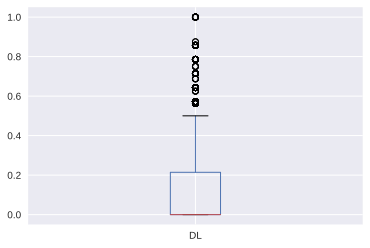

In [181]:
x_data.boxplot(column=['DL'])
plt.show()

**Conclusion** 
* This feature has a very small amount of outlaiers, near 0.56+.
* The median is around 0.113, and 0.097 after log transformation.

**'DS'**

In [182]:
x_data['DS'].value_counts()

0.0    16867
1.0       13
Name: DS, dtype: int64

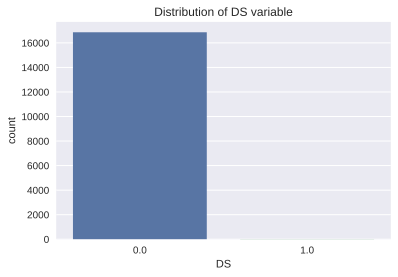

In [183]:
sns.countplot(x_data['DS']);
plt.title('Distribution of DS variable')
plt.show()

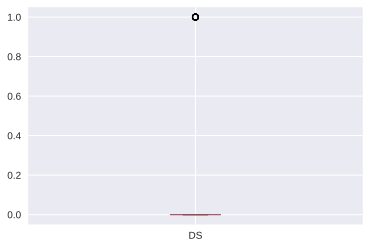

In [184]:
x_data.boxplot(column=['DS'])
plt.show()

**Conclusion** 
* This feature has a very big amount of zero values. (Practically all)
* This feature has a very small amount of outlaiers, near 1.
* The median is around 0.

**'DP'**

In [185]:
x_data['DP'].value_counts()

0.000000    16127
0.333333      572
0.500000      142
0.666667       20
1.000000       19
Name: DP, dtype: int64

In [186]:
draw_histogram(x_data['DP'])

Output hidden; open in https://colab.research.google.com to view.

In [187]:
shapiro_normality_testing(x_data['DP'])

stat=0.206, p=0.000
Probably not Gaussian


In [188]:
count_skewness_kurtosis(x_data['DP'])

Skewness: 5.547374
Kurtosis: 36.438241


* *Skewness* shows how symmetric the data is, from the value it is clear that the data is strongly biased.
* *Kurtosis* shows that the distribution is not flattened and has a long tail.
* Data looks like needed to be log transformed.

**Log transformation**

In [189]:
draw_lognorm(x_data['DP'])

Output hidden; open in https://colab.research.google.com to view.

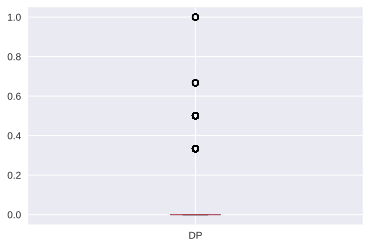

In [190]:
x_data.boxplot(column=['DP'])
plt.show()

**Conclusion** 
* This feature has a very small amount of outlaiers, near 0.3+.
* The median is around 0.017, and 0.015 after log transformation.

**'Width'**

In [191]:
draw_histogram(x_data['Width'])

Output hidden; open in https://colab.research.google.com to view.

In [192]:
shapiro_normality_testing(x_data['Width'])

stat=0.967, p=0.000
Probably not Gaussian


In [193]:
count_skewness_kurtosis(x_data['Width'])

Skewness: 0.319591
Kurtosis: -0.816352


* *Skewness* shows how symmetric the data is, from the value it is clear that the data is not biased.
* *Kurtosis* shows that the distribution is not flattened.

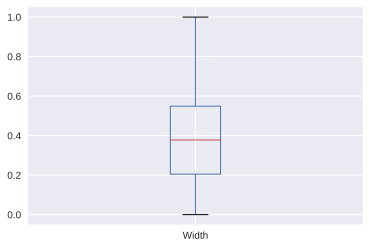

In [194]:
x_data.boxplot(column=['Width'])
plt.show()

**Conclusion** 
* This feature has no outlaiers.
* The median is around 0.4.

**'Min'**

In [195]:
draw_histogram(x_data['Min'])

Output hidden; open in https://colab.research.google.com to view.

In [196]:
shapiro_normality_testing(x_data['Min'])

stat=0.951, p=0.000
Probably not Gaussian


In [197]:
count_skewness_kurtosis(x_data['Min'])

Skewness: 0.153949
Kurtosis: -1.155465


* *Skewness* shows how symmetric the data is, from the value it is clear that the data is not strongly biased.
* *Kurtosis* shows that the distribution is not flattened.

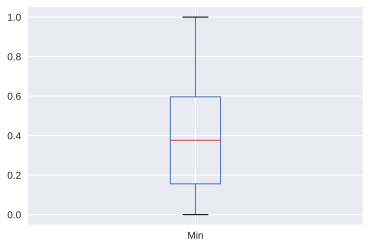

In [198]:
x_data.boxplot(column=['Min'])
plt.show()

**Conclusion** 
* This feature has no outlaiers.
* The median is around 0.38.

**'Max'**

In [199]:
draw_histogram(x_data['Max'])

Output hidden; open in https://colab.research.google.com to view.

In [200]:
shapiro_normality_testing(x_data['Max'])

stat=0.979, p=0.000
Probably not Gaussian


In [201]:
count_skewness_kurtosis(x_data['Max'])

Skewness: 0.574923
Kurtosis: 0.831475


* *Skewness* shows how symmetric the data is, from the value it is clear that the data is strongly biased.
* *Kurtosis* shows that the distribution is not flattened and has a tail.

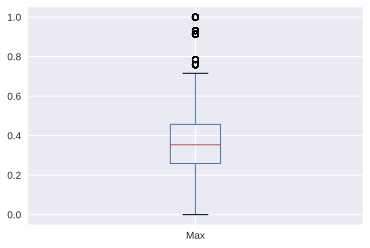

In [202]:
x_data.boxplot(column=['Max'])
plt.show()

**Conclusion** 
* This feature has a very small amount of outlaiers, near 0.7+.
* The median is around 0.36.

**'Nmax'**

In [203]:
draw_histogram(x_data['Nmax'])

Output hidden; open in https://colab.research.google.com to view.

In [204]:
shapiro_normality_testing(x_data['Nmax'])

stat=0.933, p=0.000
Probably not Gaussian


In [205]:
count_skewness_kurtosis(x_data['Nmax'])

Skewness: 0.845508
Kurtosis: 0.459515


* *Skewness* shows how symmetric the data is, from the value it is clear that the data is strongly biased.
* *Kurtosis* shows that the distribution is not flattened and has a long tail.
* Data looks like needed to be log transformed.

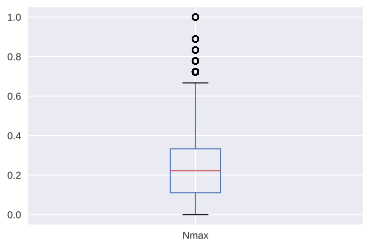

In [206]:
x_data.boxplot(column=['Nmax'])
plt.show()

**Conclusion** 
* This feature has a very small amount of outlaiers, near 0.7+.
* The median is around 0.2.

**'Nzeros'**

In [207]:
draw_histogram(x_data['Nzeros'])

Output hidden; open in https://colab.research.google.com to view.

In [208]:
shapiro_normality_testing(x_data['Nzeros'])

stat=0.526, p=0.000
Probably not Gaussian


In [209]:
count_skewness_kurtosis(x_data['Nzeros'])

Skewness: 3.589836
Kurtosis: 28.044525


* *Skewness* shows how symmetric the data is, from the value it is clear that the data is strongly biased.
* *Kurtosis* shows that the distribution is not flattened and has a long tail.
* Data looks like needed to be log transformed.

**Log transformation**

In [210]:
x_data['Nzeros'].value_counts()

0.0    12704
0.1     3054
0.2      918
0.3      161
0.5       20
0.4       11
1.0       10
0.7        1
0.8        1
Name: Nzeros, dtype: int64

In [211]:
draw_lognorm(x_data['Nzeros'])

Output hidden; open in https://colab.research.google.com to view.

**Conclusion:**  

* I'd say it looks more like a log-normal distribution, so we can try to apply log transformation.
* There are many zero-values, the average values are shifted to the left, while the distribution has a long tail. However, the variance has become less.

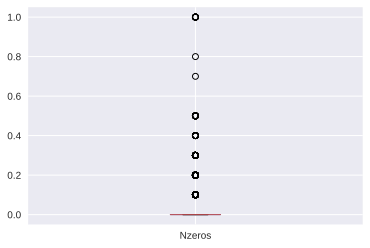

In [212]:
x_data.boxplot(column=['Nzeros'])
plt.show()

**Conclusion** 
* This feature has some outlaiers, near 0.1+.
* The median is around 0.033, and 0.031 after log transformation.

**'Mode'**

In [213]:
draw_histogram(x_data['Mode'])

Output hidden; open in https://colab.research.google.com to view.

In [214]:
shapiro_normality_testing(x_data['Mode'])

stat=0.995, p=0.000
Probably not Gaussian


In [215]:
count_skewness_kurtosis(x_data['Mode'])

Skewness: -0.099986
Kurtosis: 0.587687


* *Skewness* shows how symmetric the data is, from the value it is clear that the data is not strongly biased.
* *Kurtosis* shows that the distribution is not flattened.

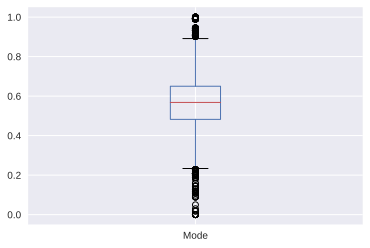

In [216]:
x_data.boxplot(column=['Mode'])
plt.show()

**Conclusion** 
* This feature has many outlaiers, near 0.2- and 0.9+.
* The median is around 0.5.

**'Mean'**

In [217]:
draw_histogram(x_data['Mean'])

Output hidden; open in https://colab.research.google.com to view.

In [218]:
shapiro_normality_testing(x_data['Mean'])

stat=0.998, p=0.000
Probably not Gaussian


In [219]:
count_skewness_kurtosis(x_data['Mean'])

Skewness: -0.042545
Kurtosis: 0.053645


* *Skewness* shows how symmetric the data is, from the value it is clear that the data is not strongly biased.
* *Kurtosis* shows that the distribution is not flattened.

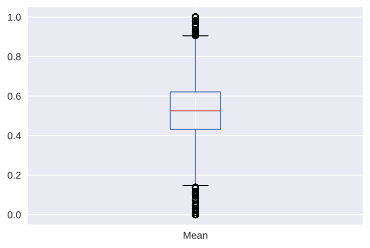

In [220]:
x_data.boxplot(column=['Mean'])
plt.show()

**Conclusion** 
* This feature has many outlaiers, near 0.2- and 0.9+.
* The median is around 0.5.

**'Median'**

In [221]:
draw_histogram(x_data['Median'])

Output hidden; open in https://colab.research.google.com to view.

In [222]:
shapiro_normality_testing(x_data['Median'])

stat=0.999, p=0.000
Probably not Gaussian


In [223]:
count_skewness_kurtosis(x_data['Median'])

Skewness: -0.043932
Kurtosis: -0.068083


* *Skewness* shows how symmetric the data is, from the value it is clear that the data is not strongly biased.
* *Kurtosis* shows that the distribution is not flattened.

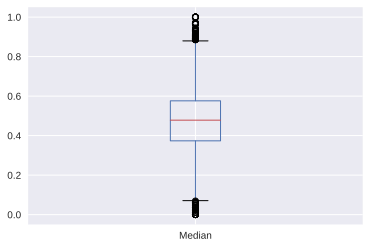

In [224]:
x_data.boxplot(column=['Median'])
plt.show()

**Conclusion** 
* This feature has many outlaiers, near 0.2- and 0.9+.
* The median is around 0.5.

**'Variance'**

In [225]:
draw_histogram(x_data['Variance'])

Output hidden; open in https://colab.research.google.com to view.

In [226]:
shapiro_normality_testing(x_data['Variance'])

stat=0.713, p=0.000
Probably not Gaussian


In [227]:
count_skewness_kurtosis(x_data['Variance'])

Skewness: 2.511094
Kurtosis: 8.265880


* *Skewness* shows how symmetric the data is, from the value it is clear that the data is strongly biased.
* *Kurtosis* shows that the distribution is not flattened and has a long tail.
* Data looks like needed to be log transformed.

**Log transformation**

In [228]:
draw_lognorm(x_data['Variance'])

Output hidden; open in https://colab.research.google.com to view.

**Conclusion:**  

* I'd say it looks more like a log-normal distribution, so we can try to apply log transformation.
* After log transformation the distribution resembles a normal one, but the average values are slightly shifted to the left, while the distribution has a small tails. However, the variance has become less.

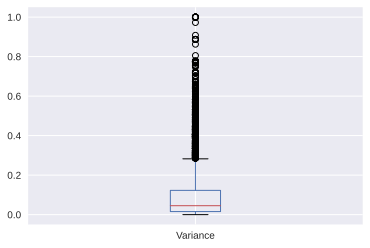

In [229]:
x_data.boxplot(column=['Variance'])
plt.show()

**Conclusion** 
* This feature has a huge amount of outlaiers, near 0.3+.
* The median is around 0.9, and 0.8 after log transformation.

**'Tendency'**

In [230]:
x_data['Tendency'].value_counts()

0.5    9028
1.0    6809
0.0    1043
Name: Tendency, dtype: int64

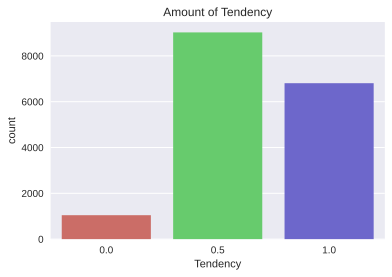

In [231]:
sns.countplot(data=x_data, x='Tendency', palette="hls")
plt.title('Amount of Tendency')
plt.show()

### **General conclusion**  
As we can see, there are quite a few observations where a feature value is more than five standard deviations away from the feature mean. These outliers might represent instrument error; but they might also be caused by fat-tails of the true distributions, in which case these values are informative. If the outliers are errors, this can negatively impact the performance of our classifiers. 

## **Correlation**

* Evaluation of the pairwise dependencies of numerical features.
* Calculation and visualization of the correlation matrix.

In [232]:
corr_matrix = cdata.corr().round(4) 
corr_matrix

,id,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,outlier
id,1.0000,0.0046,0.0557,-0.1814,0.4188,0.3668,-0.0370,-0.0197,-0.3500,0.2868,0.0193,0.0959,-0.1764,0.1629,-0.1114,-0.1195,-0.0423,-0.0461,-0.1524,-0.0564,0.0588,-0.0744,-0.0728
LB,0.0046,1.0000,0.0192,-0.0196,-0.0568,0.2628,-0.1964,0.1924,-0.0510,-0.0451,-0.0052,-0.0888,-0.0472,0.2825,0.3392,-0.0486,0.0179,0.7488,0.7580,0.8084,-0.0678,0.2982,0.0822
AC,0.0557,0.0192,1.0000,0.0794,0.1646,-0.0350,0.1416,-0.2963,-0.2128,-0.0368,-0.0136,-0.0412,0.2947,-0.1231,0.4166,0.1965,-0.0259,0.2760,0.3162,0.3189,0.1847,0.0236,-0.1202
FM,-0.1814,-0.0196,0.0794,1.0000,-0.0336,-0.0941,0.1371,-0.0718,0.0085,0.0801,-0.0051,0.2310,0.1674,-0.1565,0.1030,0.1378,-0.0148,0.0109,-0.0497,-0.0111,0.1404,0.0326,0.0135
UC,0.4188,-0.0568,0.1646,-0.0336,1.0000,0.0981,0.0827,-0.0515,-0.1351,0.3072,0.0405,0.1097,0.0451,-0.0020,0.0860,0.0212,-0.0271,-0.0398,-0.1160,-0.0574,0.1218,-0.0522,-0.0718
ASTV,0.3668,0.2628,-0.0350,-0.0941,0.0981,1.0000,-0.3691,0.2963,-0.2846,0.0089,-0.0117,-0.0497,-0.1784,0.2167,-0.0355,-0.0991,-0.1238,0.1242,0.1176,0.1810,-0.1714,0.0311,0.1901
MSTV,-0.0370,-0.1964,0.1416,0.1371,0.0827,-0.3691,1.0000,-0.3598,0.1142,0.4640,0.0027,0.1346,0.6129,-0.5736,0.3762,0.4722,0.2245,-0.1749,-0.3348,-0.2037,0.5422,0.0129,-0.0850
ALTV,-0.0197,0.1924,-0.2963,-0.0718,-0.0515,0.2963,-0.3598,1.0000,-0.1371,-0.1933,-0.0122,-0.0868,-0.3706,0.3437,-0.2311,-0.2338,-0.0644,0.0818,0.1346,0.0991,-0.2353,-0.0562,0.2755
MLTV,-0.3500,-0.0510,-0.2128,0.0085,-0.1351,-0.2846,0.1142,-0.1371,1.0000,-0.2398,0.0082,-0.1258,0.1194,-0.1750,-0.0245,0.0577,0.1214,-0.0759,0.0144,-0.0704,-0.1084,0.0959,-0.0548
DL,0.2868,-0.0451,-0.0368,0.0801,0.3072,0.0089,0.4640,-0.1933,-0.2398,1.0000,0.0012,0.2183,0.4896,-0.5117,0.2186,0.3612,0.1650,-0.1530,-0.4093,-0.2123,0.5341,0.1157,-0.0129


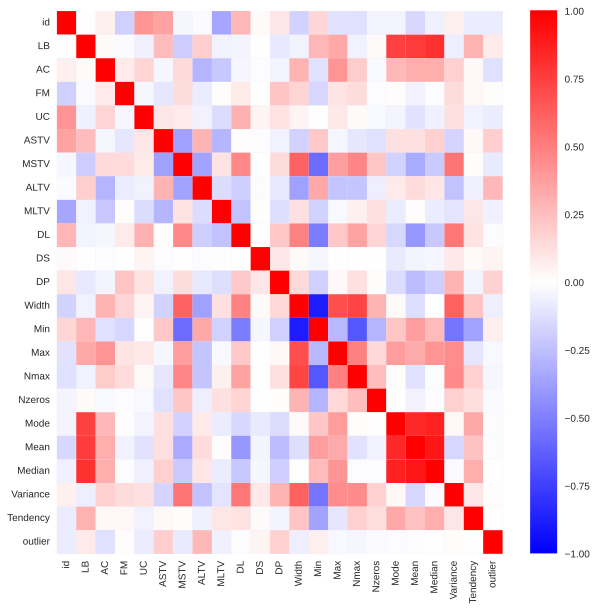

In [233]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='bwr', ax=ax)
plt.show()

**Conclusion**  
* It is important to understand that if the variables are strongly related to each other, then this can affect the training of the model in a bad way. The model will not adequately, in particular the linear model, calculate the weights and parameters of the model.

* At first glance, it is possible to distinguish a pair of red squares, the greatest dependence is observed between these features: 
      - 'LB', 'Mode'; 'LB', 'Mean'; 'LB', 'Median';
      - 'Width', 'Max'; 'Width', 'Nmax'; 
      - 'Mode' and 'Mean' and 'Median';

* Some features exhibit significant cross-correlation (both negative and positive); however, we never have exact multicollinearity. Some variables, such as the number of heartrate accelerations ('AC') and uterine contractions ('UC'), correlate positively with normal fetal status (which is coded as -1); while others, such as abnormal long and short term availability ('ALTV' and 'ASTV') and the number of prolongued heartrate deccelerations ('DP') correlate negatively, meaning higher values occur more frequently with suspect/pathological fetal status (coded as 1). Some of these correlations are substantial but there are no variables with absolute correlation coefficient above 0.5, indicating that no single feature alone can provide good predictions.

* However, there is a malticolinearity between this params.: 'Mode' and 'Mean' and 'Median'

## **Correlation coefficients**

**'LB', 'Mode'**

In [234]:
np.corrcoef(cdata['LB'], cdata['Mode'])

array([[1.        , 0.74882095],
       [0.74882095, 1.        ]])

This correlation is 0.75, a strong positive correlation, let’s take a look at a scatter chart.

In [235]:
sns.pairplot(cdata.loc[:, ['LB', 'Mode']])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

**'LB', 'Mean'**

In [236]:
np.corrcoef(cdata['LB'], cdata['Mean'])

array([[1.        , 0.75801281],
       [0.75801281, 1.        ]])

This correlation is 0.7, a strong positive correlation, let’s take a look at a scatter chart.

In [237]:
sns.pairplot(cdata.loc[:, ['LB', 'Mean']])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

**'LB', 'Median'**

In [238]:
np.corrcoef(cdata['LB'], cdata['Median'])

array([[1.        , 0.80836098],
       [0.80836098, 1.        ]])

This correlation is 0.8, a strong positive correlation, let’s take a look at a scatter chart.

In [239]:
sns.pairplot(cdata.loc[:, ['LB', 'Median']])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

**'Width', 'Max'**

In [240]:
np.corrcoef(cdata['Width'], cdata['Max'])

array([[1.        , 0.69064502],
       [0.69064502, 1.        ]])

This correlation is 0.7, a positive correlation, let’s take a look at a scatter chart.

In [241]:
sns.pairplot(cdata.loc[:, ['Width', 'Max']])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

**'Width', 'Nmax'**

In [242]:
np.corrcoef(cdata['Width'], cdata['Nmax'])

array([[1.        , 0.73378337],
       [0.73378337, 1.        ]])

This correlation is 0.7, a positive correlation, let’s take a look at a scatter chart.

In [243]:
sns.pairplot(cdata.loc[:, ['Width', 'Nmax']])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

**'Mode', 'Mean', 'Median'**

In [244]:
print(np.corrcoef(cdata['Mode'], cdata['Median']))

print(np.corrcoef(cdata['Mode'], cdata['Mean']))

print(np.corrcoef(cdata['Mean'], cdata['Median']))

[[1.         0.86882363]
 [0.86882363 1.        ]]
[[1.         0.84297908]
 [0.84297908 1.        ]]
[[1.         0.90811191]
 [0.90811191 1.        ]]


In [245]:
sns.pairplot(cdata.loc[:, ['Mean', 'Median']])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## **Dropping highly correlated features**

In [24]:
cdata.drop(['Mode', 'Mean', 'Median'], axis=1, inplace=True)

# **Preprocessing**

## **Dropping duplicates**

ID feature is unique for each row -> playes no role for futher work.

In [25]:
cdata.drop('id', axis=1, inplace=True)

Then I drop duplicates in Dataset.

In [26]:
cdata.shape

(16880, 19)

In [27]:
cdata.drop_duplicates(inplace=True)
cdata.shape

(16726, 19)

* 154 duplicates were found & deleted.

## **Log transformation**

In [28]:
to_log_features = ['AC', 'FM',	'UC', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DP', 'Nzeros', 'Variance']
for feat in to_log_features:
  cdata[feat] = np.log1p(cdata[feat])

In [29]:
cdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16726 entries, 0 to 16879
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LB        16726 non-null  float64
 1   AC        16726 non-null  float64
 2   FM        16726 non-null  float64
 3   UC        16726 non-null  float64
 4   ASTV      16726 non-null  float64
 5   MSTV      16726 non-null  float64
 6   ALTV      16726 non-null  float64
 7   MLTV      16726 non-null  float64
 8   DL        16726 non-null  float64
 9   DS        16726 non-null  float64
 10  DP        16726 non-null  float64
 11  Width     16726 non-null  float64
 12  Min       16726 non-null  float64
 13  Max       16726 non-null  float64
 14  Nmax      16726 non-null  float64
 15  Nzeros    16726 non-null  float64
 16  Variance  16726 non-null  float64
 17  Tendency  16726 non-null  float64
 18  outlier   16726 non-null  int64  
dtypes: float64(18), int64(1)
memory usage: 2.6 MB


In [30]:
NUNERICAL = list(cdata.select_dtypes(include=['number']).columns)
NUNERICAL.remove(target)
NUNERICAL

['LB',
 'AC',
 'FM',
 'UC',
 'ASTV',
 'MSTV',
 'ALTV',
 'MLTV',
 'DL',
 'DS',
 'DP',
 'Width',
 'Min',
 'Max',
 'Nmax',
 'Nzeros',
 'Variance',
 'Tendency']

In [31]:
X = cdata[NUNERICAL]
y = cdata[target]

## **PCA**


In [32]:
dim_reducer = PCA(n_components=2)
x_reduced = dim_reducer.fit_transform(X)
x_reduced.shape

(16726, 2)

In [33]:
sns.scatterplot(x_reduced[:,0], x_reduced[:,1], hue=y)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## **Split**

**! for SUPERVISED methods**

In [34]:
x_data = cdata[NUNERICAL]
y_data = cdata[target]

For supervised learning algorithms:

In [35]:
trainData, testData, train_label, test_label = train_test_split(x_data,
                                                                y_data,
                                                                stratify=y_data,
                                                                test_size=0.2,
                                                                random_state=42)

print('Size of train set:', trainData.shape)
print('Size of test set:', testData.shape)

print('\nClass distribution on train:',
      train_label.value_counts(normalize=True),
      '\nClass distribution on test:', 
      test_label.value_counts(normalize=True),
      sep='\n')

Size of train set: (13380, 18)
Size of test set: (3346, 18)

Class distribution on train:
0    0.980419
1    0.019581
Name: outlier, dtype: float64

Class distribution on test:
0    0.980574
1    0.019426
Name: outlier, dtype: float64


# **Metrics**

**Metric selection**  
Use precision and recall to focus on small positive class — When the positive class is smaller and the ability to detect correctly positive samples is our main focus (correct detection of negatives examples is less important to the problem) we should use precision and recall.

**We use ROC when both classes detection is equally important** — When we want to give equal weight to both classes prediction ability we should look at the ROC curve.  

**Thus, I'll use precision and recall for this issue and dataset**

In [36]:
def calc_metrics(test_label, preds):

    skplt.metrics.plot_confusion_matrix(test_label, preds, 
                                    normalize=False,
                                    title="Consfusion Matrix on Test Set")
    plt.show()

    print('\n\nClassification report:\n')
    print(metrics.classification_report(test_label, preds, digits=5))

# **Mahalanobis rule**

Mahalanobis distance is an effective multivariate distance metric that measures the distance between a point and a distribution. It is an extremely useful metric having, excellent applications in multivariate anomaly detection, classification on highly imbalanced datasets and one-class classification.

In [37]:
X = x_data.copy(deep=True)

## **Detection of multidimensional outliers using the Mahalanobis distance**

In [38]:
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()


X['mahala'] = mahalanobis(x=X, data=X)
X.head()

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Variance,Tendency,mahala
0,0.592593,0.00000,0.000000,0.257829,0.633803,0.291352,0.000000,0.013712,0.405465,0.0,0.000000,0.595376,0.045872,0.336207,0.333333,0.09531,0.493731,1.0,39.583679
1,0.574074,0.03774,0.000000,0.000000,0.816901,0.028988,0.423614,0.088654,0.000000,0.0,0.000000,0.364162,0.770642,0.672414,0.166667,0.00000,0.016807,0.0,33.469252
2,0.777778,0.00000,0.000000,0.000000,0.774648,0.028988,0.551736,0.092257,0.000000,0.0,0.000000,0.069364,0.816514,0.275862,0.222222,0.00000,0.000000,1.0,33.134825
3,0.259259,0.00000,0.000000,0.257829,0.704225,0.174941,0.000000,0.168419,0.356675,0.0,0.287682,0.473988,0.174312,0.275862,0.222222,0.09531,0.308647,0.0,39.937439
4,0.592593,0.00000,0.001771,0.257829,0.633803,0.302281,0.000000,0.013712,0.356675,0.0,0.287682,0.595376,0.045872,0.336207,0.333333,0.09531,0.520944,1.0,47.668920


Сount the P values to determine whether the observation is extreme or not:

In [39]:
# Compute the P-Values
X['p_value'] = 1 - chi2.cdf(X['mahala'], 2)

# Extreme values with a significance level of 0.01
X.loc[X.p_value < 0.01].head(10)

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Variance,Tendency,mahala,p_value
0,0.592593,0.00000,0.000000,0.257829,0.633803,0.291352,0.000000,0.013712,0.405465,0.0,0.000000,0.595376,0.045872,0.336207,0.333333,0.09531,0.493731,1.0,39.583679,2.538127e-09
1,0.574074,0.03774,0.000000,0.000000,0.816901,0.028988,0.423614,0.088654,0.000000,0.0,0.000000,0.364162,0.770642,0.672414,0.166667,0.00000,0.016807,0.0,33.469252,5.398142e-08
2,0.777778,0.00000,0.000000,0.000000,0.774648,0.028988,0.551736,0.092257,0.000000,0.0,0.000000,0.069364,0.816514,0.275862,0.222222,0.00000,0.000000,1.0,33.134825,6.380639e-08
3,0.259259,0.00000,0.000000,0.257829,0.704225,0.174941,0.000000,0.168419,0.356675,0.0,0.287682,0.473988,0.174312,0.275862,0.222222,0.09531,0.308647,0.0,39.937439,2.126647e-09
4,0.592593,0.00000,0.001771,0.257829,0.633803,0.302281,0.000000,0.013712,0.356675,0.0,0.287682,0.595376,0.045872,0.336207,0.333333,0.09531,0.520944,1.0,47.668920,4.454770e-11
5,0.629630,0.00000,0.021053,0.000000,0.915493,0.000000,0.642432,0.070438,0.000000,0.0,0.000000,0.028902,0.788991,0.189655,0.055556,0.00000,0.000000,0.5,36.849944,9.957180e-09
6,0.648148,0.00000,0.012335,0.000000,0.830986,0.028988,0.551736,0.193111,0.000000,0.0,0.000000,0.433526,0.174312,0.215517,0.111111,0.00000,0.011236,1.0,35.334735,2.124026e-08
7,0.425926,0.00000,0.001771,0.344840,0.760563,0.323787,0.000000,0.000000,0.356675,0.0,0.693147,0.526012,0.000000,0.189655,0.333333,0.00000,0.060292,0.5,129.582106,0.000000e+00
8,0.574074,0.00000,0.033133,0.000000,0.732394,0.043172,0.123869,0.194736,0.000000,0.0,0.000000,0.473988,0.165138,0.267241,0.111111,0.00000,0.016807,1.0,14.869917,5.902535e-04
9,0.648148,0.00000,0.003540,0.000000,0.901408,0.000000,0.519578,0.081407,0.000000,0.0,0.000000,0.052023,0.770642,0.206897,0.055556,0.00000,0.000000,0.5,26.059751,2.193800e-06


In [40]:
predictions = np.zeros(x_data.shape[0])
predictions[X.p_value < 0.01] = 1

In [41]:
sns.scatterplot(x_reduced[:,0], x_reduced[:,1], hue=predictions)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

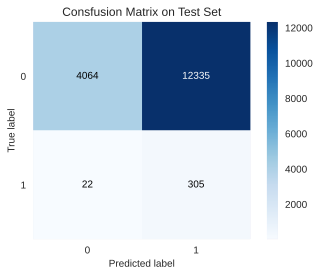



Classification report:

              precision    recall  f1-score   support

           0    0.99462   0.24782   0.39678     16399
           1    0.02413   0.93272   0.04704       327

    accuracy                        0.26121     16726
   macro avg    0.50937   0.59027   0.22191     16726
weighted avg    0.97564   0.26121   0.38994     16726



In [46]:
calc_metrics(y_data, predictions)

**Conclusion**
* This model defines both classes in a vety bad way.
* Looking at *f1-score* metric, for example: "0" class (39%) and "1" class for 4%, which is very bad. 
* The *precision and recall* metrics show an almost bad results for "0" class and "1" class.


## **Mahalanobis distance for classification problems**

In [47]:
class MahalanobisBinaryClassifier():
    def __init__(self, xtrain, ytrain):
        self.xtrain_pos = xtrain.loc[ytrain == 1, :]
        self.xtrain_neg = xtrain.loc[ytrain == 0, :]

    def predict_proba(self, xtest):
        pos_neg_dists = [(p,n) for p, n in zip(mahalanobis(xtest, self.xtrain_pos), mahalanobis(xtest, self.xtrain_neg))]
        return np.array([(1-n/(p+n), 1-p/(p+n)) for p,n in pos_neg_dists])

    def predict(self, xtest):
        return np.array([np.argmax(row) for row in self.predict_proba(xtest)])


clf = MahalanobisBinaryClassifier(trainData, train_label)        
pred_probs = clf.predict_proba(testData)
pred_class = clf.predict(testData)

# Pred and Truth
pred_actuals = pd.DataFrame([(pred, act) for pred, act in zip(pred_class, test_label)], columns=['pred', 'true'])
print(pred_actuals[:5])  

   pred  true
0     0     0
1     0     0
2     0     0
3     0     0
4     0     0


In [48]:
truth = pred_actuals.loc[:, 'true']
pred = pred_actuals.loc[:, 'pred']
scores = np.array(pred_probs)[:, 1]

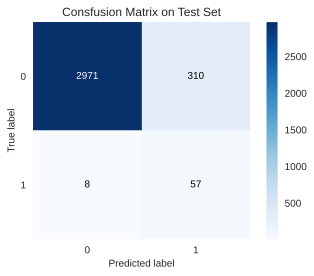



Classification report:

              precision    recall  f1-score   support

           0    0.99731   0.90552   0.94920      3281
           1    0.15531   0.87692   0.26389        65

    accuracy                        0.90496      3346
   macro avg    0.57631   0.89122   0.60655      3346
weighted avg    0.98096   0.90496   0.93589      3346



In [50]:
calc_metrics(truth, pred)

**Conclusion**
* This model defines both classes in a vety bad way.
* Looking at *f1-score* metric, for example: "0" class (39%) and "1" class for 4%, which is very bad. 
* The *precision and recall* metrics show an almost bad results for "0" class and "1" class.

* This classifier identifies "0" class very good and "1" class for 26% which is bad. This fact is also confirmed by the *f1-score* metric.
* The **precision and recall** metrics show an almost perfect result for "0" class and "1" class is not so perfect.





# **Supervised models**

## **Standartisation**

* Since we are working with distances between objects, heterogeneity in the values of features can greatly distort the results of the analysis. So, a feature that itself takes high values can be decisive when calculating distances, while features with low values may have almost no effect.
* To solve this problem, I later perform *STANDARDIZATION* of the data.


In [93]:
cdata.describe(include='all')

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Variance,Tendency,outlier
count,16726.000000,16726.000000,16726.000000,16726.000000,16726.000000,16726.000000,16726.000000,16726.000000,16726.000000,16726.000000,16726.000000,16726.000000,16726.000000,16726.000000,16726.000000,16726.000000,16726.000000,16726.000000,16726.000000
mean,0.483307,0.114956,0.010130,0.197261,0.425398,0.160783,0.054227,0.152947,0.097720,0.000777,0.014679,0.392711,0.378010,0.366782,0.231542,0.031099,0.082511,0.671201,0.019550
std,0.175599,0.118805,0.047422,0.124169,0.216763,0.095951,0.116001,0.093702,0.140108,0.027869,0.069776,0.214862,0.251512,0.153078,0.159237,0.061419,0.098764,0.295306,0.138453
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.351852,0.000000,0.000000,0.111226,0.236111,0.084557,0.000000,0.090457,0.000000,0.000000,0.000000,0.205882,0.155963,0.258621,0.111111,0.000000,0.016349,0.500000,0.000000
50%,0.481481,0.074108,0.000000,0.211309,0.408451,0.149940,0.000000,0.144809,0.000000,0.000000,0.000000,0.379518,0.366972,0.353448,0.222222,0.000000,0.044206,0.500000,0.000000
75%,0.592593,0.175891,0.003540,0.265703,0.611111,0.199333,0.046520,0.204429,0.194156,0.000000,0.000000,0.550296,0.596330,0.456897,0.333333,0.000000,0.117155,1.000000,0.000000
max,1.000000,0.693147,0.693147,0.693147,1.000000,0.693147,0.693147,0.693147,0.693147,1.000000,0.693147,1.000000,1.000000,1.000000,1.000000,0.693147,0.693147,1.000000,1.000000


In [140]:
scaler = StandardScaler()
trainData = scaler.fit_transform(trainData)
testData = scaler.transform(testData)

## **SMOTE**

Firstly, I thought that this method would help to solve the issue better, but it didn't. So, I commented it.

In [136]:
# sm = SMOTE(random_state = 42)
           
# trainData, train_label = sm.fit_sample(trainData, train_label) 

## **SVM**

In [203]:
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(trainData, train_label)
score = classifier.score(testData, test_label, sample_weight=None) 

y_pred = classifier.predict(testData)

**Quality assessment**

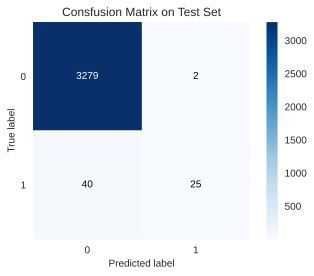



Classification report:

              precision    recall  f1-score   support

           0    0.98795   0.99939   0.99364      3281
           1    0.92593   0.38462   0.54348        65

    accuracy                        0.98745      3346
   macro avg    0.95694   0.69200   0.76856      3346
weighted avg    0.98674   0.98745   0.98489      3346



In [204]:
calc_metrics(test_label, y_pred)

**Conclusion**

* A score of 98% is fairly high for a non tuned algorithm. It also got a perfect score when it comes to detecting cases classified as 1(yes-outlier), which is exactly the kind of criteria we're looking for when making a medical outliers classifier. This score and this confusion matrix will be used in the next part as a comparison point with the other scores and confusion matrixes of other algorithms.

* My classifier identifies "0" class very good and "1" class for 50% which is not so good. This fact is also confirmed by the *f1-score* metric.
* The **precision and recall** metrics show an almost perfect result for "0" class and "1" class is not so perfect. (0.9, 0.4 are  the results) 


### **Hyperparameters tuning**

In [153]:
parameters = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}

grid_search = GridSearchCV(SVC(),param_grid = parameters, refit = True, verbose = 1)
grid_search = grid_search.fit(trainData, train_label)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print(best_accuracy)
print(best_parameters)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.1min finished


0.9951420029895367
{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}


**Now we will train the model with the selected parameters**

In [155]:
classifier = SVC(random_state = 0, C=1000, gamma=0.1, kernel='rbf') # Choosing a linear Kernel for SVC and not K-svc
classifier.fit(trainData, train_label)# Fitting the classifier onto our dataset
score = classifier.score(testData, test_label, sample_weight=None) # Checking how well it did

# Predicting the Test set results
y_pred = classifier.predict(testData) # Still all pretty good

**Quality assessment**

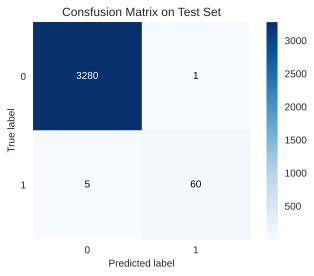



Classification report:

              precision    recall  f1-score   support

           0    0.99848   0.99970   0.99909      3281
           1    0.98361   0.92308   0.95238        65

    accuracy                        0.99821      3346
   macro avg    0.99104   0.96139   0.97573      3346
weighted avg    0.99819   0.99821   0.99818      3346



In [156]:
calc_metrics(test_label, y_pred)

**Conclusion**

*	After tuning the hyperparameters, the situation has changed and became better.

* A score of 99% is fairly high.
* My classifier identifies all classes perfectlly. This fact is also confirmed by the *precision and recall, f1-score* metrics.



## **Logistic regression**

**Tunning params.:**

In [157]:
params = {
    'C':  [0.05, 0.1, 0.5, 1, 3, 5],
    'tol':  [0.05, 0.1, 0.5, 1, 2, 10],
}

In [158]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
lr = LogisticRegression()

gd = GridSearchCV(lr,
                   params,
                   cv=rskf, 
                   scoring='f1',
                   n_jobs=5)

In [159]:
gd.fit(trainData, train_label)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=5,
             param_grid={'C': [0.05, 0.1, 0.5, 1, 3, 5],
                         'tol': [0.05, 0.1, 0.5, 1, 2, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [160]:
gd.best_params_

{'C': 5, 'tol': 2}

**Now we will train the model with the selected parameters**

In [161]:
lgr = LogisticRegression(C=5,
                         tol=2)

In [162]:
lgr.fit(trainData, train_label)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=2, verbose=0,
                   warm_start=False)

In [163]:
%%time
pred = lgr.predict(testData)

CPU times: user 1.42 ms, sys: 11 µs, total: 1.43 ms
Wall time: 2.99 ms


**Quality assessment**

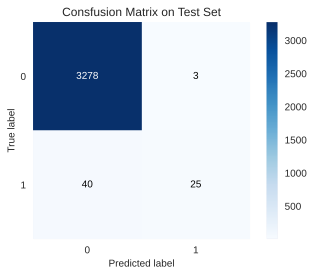



Classification report:

              precision    recall  f1-score   support

           0    0.98794   0.99909   0.99348      3281
           1    0.89286   0.38462   0.53763        65

    accuracy                        0.98715      3346
   macro avg    0.94040   0.69185   0.76556      3346
weighted avg    0.98610   0.98715   0.98463      3346



In [164]:
calc_metrics(test_label, pred)

**Conclusion**

* My classifier identifies "0" class very good and "1" class for 50% which is not so good. This fact is also confirmed by the *f1-score* metric.
* The **precision and recall** metrics show an almost perfect result for "0" class and "1" class is not so perfect. (0.9, 0.4 are  the results) 
* The logistic regression mogel is not so good at this issue.

## **KNN**

In [165]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(trainData,train_label)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [166]:
pred = knn.predict(testData)

**Quality assessment**

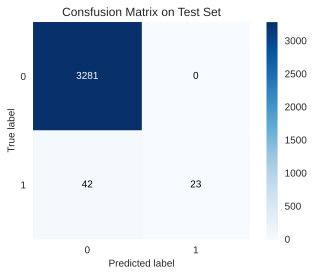



Classification report:

              precision    recall  f1-score   support

           0    0.98736   1.00000   0.99364      3281
           1    1.00000   0.35385   0.52273        65

    accuracy                        0.98745      3346
   macro avg    0.99368   0.67692   0.75818      3346
weighted avg    0.98761   0.98745   0.98449      3346



In [167]:
calc_metrics(test_label, pred)

**Conclusion**

* My classifier identifies "0" class very good and "1" class for 50% which is not so good. This fact is also confirmed by the *f1-score* metric.
* The **precision and recall** metrics show an almost perfect result for "0" class and "1" class is not so perfect. (0.9, 0.35 are  the results) 
* So. we shouldn't trust this model.




**Tunning params.:**

In [168]:
parameters = {'n_neighbors': [3 ,5, 10, 50],
              'metric': ['euclidean', 'minkowski', 'manhattan'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_search = GridSearchCV(KNeighborsClassifier(),param_grid = parameters, refit = True, verbose = 1)
grid_search = grid_search.fit(trainData, train_label)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print(best_accuracy)
print(best_parameters)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  3.6min finished


0.9926756352765322
{'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3}


**Now we will train the model with the selected parameters:**

In [169]:
knn = KNeighborsClassifier(n_neighbors=3,
                           metric='manhattan', 
                           weights='uniform', 
                           n_jobs=-1,
                           algorithm='auto')

knn.fit(trainData, train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')

In [170]:
%%time
pred = knn.predict(testData)

CPU times: user 1.31 s, sys: 5.71 ms, total: 1.31 s
Wall time: 804 ms


**Quality evaluation**

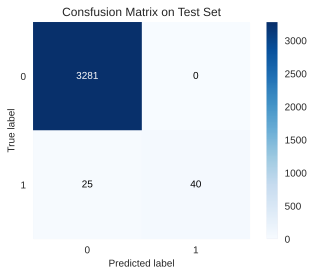



Classification report:

              precision    recall  f1-score   support

           0    0.99244   1.00000   0.99620      3281
           1    1.00000   0.61538   0.76190        65

    accuracy                        0.99253      3346
   macro avg    0.99622   0.80769   0.87905      3346
weighted avg    0.99258   0.99253   0.99165      3346



In [171]:
calc_metrics(test_label, pred)

**Conclusion**

* This model is better then the logistic regression model, but worther than the SVM model. We can see it by metrics' scores. However, the result is not so bad.
* My classifier identifies "0" class extrimally and "1" class for 76% which is not so good. This fact is also confirmed by the *f1-score* metric.
* The *precision and recall* metrics show an almost perfect result for "0" class and "1" class is not so perfect . (1.0, 0.6 are  the results) 




## **Compare different SUPERVISED models (select the best)**

Looking at these 3 models, I can say that the most stable and showing** the best** metrics was **the SVM model** after tuning the parameters:
   
        precision   recall    f1-score       support
     0    0.99848   0.99970   0.99909        3281  
     1    0.98361   0.92308   0.95238        65

**The worst** thing was **the Logistic regression**, even after tuning the parameters:
           
           precision recall  f1-score     support
      0    0.98794   0.99909   0.99348      3281
      1    0.89286   0.38462   0.53763        65

# **Unsupervised models**

## **Standartisation**

In [172]:
Scaler=StandardScaler()
x_data=Scaler.fit_transform(x_data)

## **One-class SVM**

### **Simple model**

In [185]:
ocsvm = OneClassSVM()
svm_preds = ocsvm.fit_predict(x_data)

**Quality evaluation**

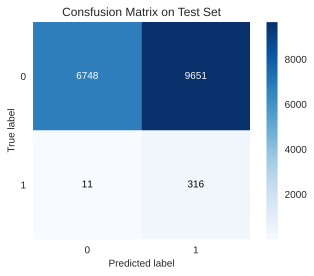



Classification report:

              precision    recall  f1-score   support

           0    0.99837   0.41149   0.58278     16399
           1    0.03170   0.96636   0.06139       327

    accuracy                        0.42234     16726
   macro avg    0.51504   0.68892   0.32209     16726
weighted avg    0.97947   0.42234   0.57259     16726



In [187]:
calc_metrics1(y_data, svm_preds)

**Conclusion**

* In general, it can be seen that without setting parameters, the model does not define classes well.

* This model identifies "0" class a little bit higher then bad (58%) and "1" class for 0.06% which is veeery bad. This fact is also confirmed by the *f1-score* metric.
* The *precision and recall* metrics show an almost bad result for "0" class and "1" class is not so perfect.


### **Hyperparameters tuning**

In [173]:
gammas = np.logspace(-9, -8, 13)
   
for g in gammas:
    print (f'GAMMA {g}:')
    detector = OneClassSVM(gamma=g)
    svm_predictions = detector.fit_predict(x_data)
    report(y_data, svm_predictions)
    print('******************************************')


GAMMA 1e-09:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     16399
           1       0.14      0.20      0.17       327

    accuracy                           0.96     16726
   macro avg       0.56      0.59      0.57     16726
weighted avg       0.97      0.96      0.96     16726

******************************************
GAMMA 1.2115276586285901e-09:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     16399
           1       0.12      0.27      0.17       327

    accuracy                           0.95     16726
   macro avg       0.55      0.62      0.57     16726
weighted avg       0.97      0.95      0.96     16726

******************************************
GAMMA 1.4677992676220676e-09:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     16399
           1       0.12      0.36      0.18       327

    accuracy           

In [612]:
nus=np.linspace(0.01, 0.25, 99)
   
for n in nus:
    print (f'NU {n}:')
    detector = OneClassSVM(gamma=1.4677992676220676e-09, nu=n)
    svm_predictions = detector.fit_predict(x_data)
    report(y_data, svm_predictions)
    print('******************************************')


NU 0.01:
              precision    recall  f1-score   support

           0       0.99      0.64      0.78     16399
           1       0.04      0.82      0.08       327

    accuracy                           0.64     16726
   macro avg       0.52      0.73      0.43     16726
weighted avg       0.98      0.64      0.76     16726

******************************************
NU 0.012448979591836735:
              precision    recall  f1-score   support

           0       1.00      0.23      0.38     16399
           1       0.02      0.96      0.05       327

    accuracy                           0.25     16726
   macro avg       0.51      0.60      0.21     16726
weighted avg       0.98      0.25      0.37     16726

******************************************
NU 0.01489795918367347:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     16399
           1       0.02      1.00      0.04       327

    accuracy                          

**Now we will train the model with the selected parameters**

In [188]:
detector = OneClassSVM(gamma=1.4677992676220676e-09, nu=0.05897959183673469)
svm_predictions = detector.fit_predict(x_data)

In [189]:
sns.scatterplot(x_reduced[:,0], x_reduced[:,1], hue=svm_predictions)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

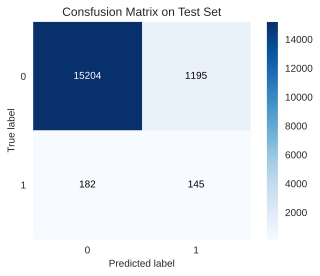



Classification report:

              precision    recall  f1-score   support

           0    0.98817   0.92713   0.95668     16399
           1    0.10821   0.44343   0.17397       327

    accuracy                        0.91767     16726
   macro avg    0.54819   0.68528   0.56532     16726
weighted avg    0.97097   0.91767   0.94138     16726



In [190]:
calc_metrics1(y_data, svm_predictions)

**Conclusion**

* The situation has changed after tuning the parametrs.
* This model starts to identify "0" class better(90%+) and "1" class for 17% which is still bad. This fact is also confirmed by the *f1-score* metric.
* The *precision and recall* metrics show an almost good result for "0" class and "1" class is not so perfect.


## **Isolation Forest**

### **Simple model**

In [193]:
iso_forest =  IsolationForest()
iso_predictions = iso_forest.fit_predict(x_data)

**Quality evaluation**

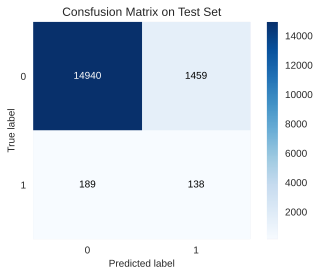



Classification report:

              precision    recall  f1-score   support

           0    0.98751   0.91103   0.94773     16399
           1    0.08641   0.42202   0.14345       327

    accuracy                        0.90147     16726
   macro avg    0.53696   0.66652   0.54559     16726
weighted avg    0.96989   0.90147   0.93201     16726



In [194]:
calc_metrics1(y_data, iso_predictions)

**Conclusion**

* In general, it can be seen that without setting parameters, the model defines only "0" class well.

* This model identifies "0" classvery well (90%+) and "1" class for 14% which is veeery bad. This fact is also confirmed by the *f1-score* metric.
* The *precision and recall* metrics show an almost bad result for "0" class and "1" class is not so perfect.


### **Hyperparameters tuning**

In [195]:
model  =  IsolationForest(n_estimators=50, max_samples=500, contamination=.01, max_features=2, 
                         bootstrap=False, n_jobs=1, random_state=1, verbose=0, warm_start=False).fit(x_data)
# Get Anomaly Scores and Predictions
anomaly_score = model.decision_function(x_data)
predictions = model.predict(x_data)

# To Plot Predictions
plt.figure(figsize = (10, 6), dpi = 150)
s = plt.scatter(x_reduced[:,0], x_reduced[:,1], c = predictions, cmap = 'coolwarm')
plt.colorbar(s, label = 'More Negative = More Anomalous')
plt.xlabel('Var 1', fontsize = 16)
plt.ylabel('Var 2', fontsize = 16)
plt.grid()
plt.title('Contamination = 0.01', weight = 'bold')

Output hidden; open in https://colab.research.google.com to view.

In [197]:
for c in [0.01, 0.02, 0.1, 0.2, 0.3, 0.5]:
    print(f'contamination {c}')
    model  =  IsolationForest(n_estimators=50, max_samples=500, contamination=c, max_features=2, 
                            bootstrap=False, n_jobs=1, random_state=1, verbose=0, warm_start=False).fit(x_data)
    # Get Anomaly Scores and Predictions
    anomaly_score = model.decision_function(x_data)
    predictions = model.predict(x_data)
    report(y_data, predictions)
    print('******************************************')

contamination 0.01
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     16399
           1       0.12      0.06      0.08       327

    accuracy                           0.97     16726
   macro avg       0.55      0.53      0.54     16726
weighted avg       0.96      0.97      0.97     16726

******************************************
contamination 0.02
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     16399
           1       0.12      0.12      0.12       327

    accuracy                           0.97     16726
   macro avg       0.55      0.55      0.55     16726
weighted avg       0.97      0.97      0.97     16726

******************************************
contamination 0.1
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     16399
           1       0.10      0.49      0.16       327

    accuracy                           0

**Now we will train the model with the selected parameters**

In [198]:
iso_forest =  IsolationForest(n_estimators=50, max_samples=500, contamination=0.02, max_features=2, 
                            bootstrap=False, n_jobs=1, random_state=1, verbose=0, warm_start=False).fit(x_data)
iso_predictions = iso_forest.predict(x_data)

In [199]:
sns.scatterplot(x_reduced[:,0], x_reduced[:,1], hue=iso_predictions)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

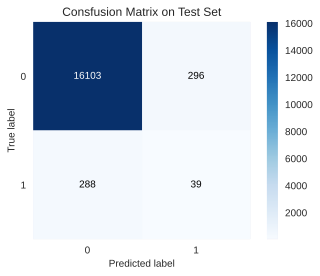



Classification report:

              precision    recall  f1-score   support

           0    0.98243   0.98195   0.98219     16399
           1    0.11642   0.11927   0.11782       327

    accuracy                        0.96508     16726
   macro avg    0.54942   0.55061   0.55001     16726
weighted avg    0.96550   0.96508   0.96529     16726



In [200]:
calc_metrics1(y_data, iso_predictions)

**Conclusion**

* The situation has changed a little after tuning the parametrs.
* The model has become better able to determine the class "0", it is probably necessary to approach the tuning of parameters more precisely.
* This model starts to identify "0" class better(98%+) and "1" class for 11% which is still bad. This fact is also confirmed by the *f1-score* metric.
* The *precision and recall* metrics show an almost good result for "0" class and "1" class is not so perfect.


## **Compare different UNSUPERVISED models (select the best)**

Looking at these 2 models, I can say that both models are not good at this issue and dataset. Maybe I should tune the parametrs better. But more stable and showing **better** metrics' scores was **the OSVM model** after tuning the parameters, because it identifies "1" class a little bit better:
   
           precision recall    f1-score    support
      0    0.98817   0.92713   0.95668     16399
      1    0.10821   0.44343   0.17397       327

**The Isolation forest** showes  **worse** results, even after tuning the parameters:
           
             precision recall    f1-score    support
        0    0.98243   0.98195   0.98219     16399
        1    0.11642   0.11927   0.11782       327